# EDA Cervix Cancer 

In [2]:
#Dependancies 
import numpy as np 
import pandas as pd
import seaborn as sns 
import cv2
import skimage.io as io
import keras
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls 
py.init_notebook_mode(connected=True)
import random 
import shutil

from skimage.io import imread, imshow
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers

from subprocess import check_output
print(check_output(["ls", "/home/kray/Practicum/train"]).decode("utf8"))

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


Type_1
Type_2
Type_3



249 photos of cervix type Type_1
781 photos of cervix type Type_2
450 photos of cervix type Type_3


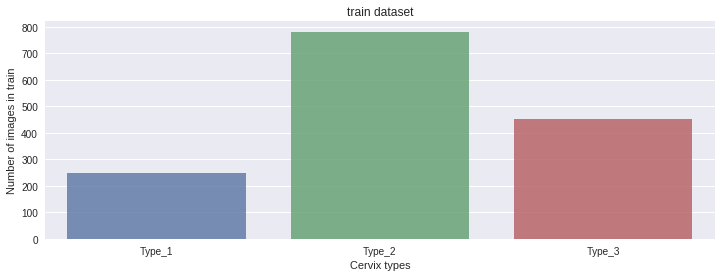

In [3]:
# Number of images for each cervix type in train with plot.
# Code modified from Poonam Ligade, Intel cervical cancer EDA https://www.kaggle.com/poonaml/intel-cervical-cancer-eda 
sub_folders = check_output(["ls", "/home/kray/Practicum/train"]).decode("utf8").strip().split('\n')
count_dict = {}
for sub_folder in sub_folders:
    num_of_files = len(check_output(["ls", "/home/kray/Practicum/train/"+sub_folder]).decode("utf8").strip().split('\n'))
    print("{0} photos of cervix type {1}".format(num_of_files, sub_folder))
                            
    count_dict[sub_folder] = num_of_files
                            
plt.figure(figsize=(12,4))
sns.barplot(list(count_dict.keys()), list(count_dict.values()), alpha = 0.8)
plt.xlabel('Cervix types', fontsize = 11)
plt.ylabel('Number of images in train', fontsize = 11)
plt.title('train dataset')
                            
plt.show()

In [4]:
#Number of test images. 
num_test_files = len(check_output(["ls", "/home/kray/Practicum/test/"]).decode("utf8").strip().split('\n'))
print("Number of test images present:", num_test_files)

Number of test images present: 512


In [5]:
fig = plt.figure(figsize = (12, 8))

i = 1
for t in "/home/kray/Practicum/train"

SyntaxError: invalid syntax (<ipython-input-5-90baa4da0deb>, line 4)

In [10]:
# Image size distribution, barplot. 
# Code modified from Poonam Ligade, Intel cervical cancer EDA https://www.kaggle.com/poonaml/intel-cervical-cancer-eda 

plt.figure(figsize=(12,4))
#sns.barplot(list(different_file_sizes.values()), list(different_file_sizes.keys()), alpha = 0.8)
import pprint
pprint.pprint(different_file_sizes)
#plt.ylabel('Image size', fontsize = 11)plt.xlabel('Number of images in train', fontsize = 11)
plt.title("Image sizes present in train dataset")
plt.show()

NameError: name 'different_file_sizes' is not defined

In [11]:
#Split data into training and validation sets, keeping file organization. 
allFiles = glob.glob('/home/kray/Practicum/train/*/*')

split_point = int(round(0.7*len(allFiles)))
random.shuffle(allFiles)

train_list = allFiles[:split_point]
valid_list = allFiles[split_point:]
print('Train images: {}'.format(len(train_list)))
print('Validation images {}'. format(len(valid_list)))

# Divy them into their own directories.
train_data_path = '/home/kray/Practicum/train_data'
validation_data_path = '/home/kray/Practicum/valid_data'
if not os.path.exists(train_data_path):
    os.makedirs(train_data_path)
if not os.path.exists(validation_data_path):
    os.makedirs(validation_data_path)

for fpath in train_list:
    basename = fpath.split('/')[-2:]
    dest = '/'.join([train_data_path] +basename)
    if not os.path.exists('/'.join(dest.split('/')[:-1])):
        os.makedirs('/'.join(dest.split('/')[:-1]))
    shutil.copyfile(fpath, '/'.join([train_data_path] +basename))
for fpath in valid_list:
    basename = fpath.split('/')[-2:]
    dest = '/'.join([validation_data_path] +basename)
    if not os.path.exists('/'.join(dest.split('/')[:-1])):
        os.makedirs('/'.join(dest.split('/')[:-1]))
    shutil.copyfile(fpath, '/'.join([validation_data_path] +basename))

Train images: 1036
Validation images 444


In [24]:
# Create numpy array
train_image_list = list()
train_label_list = list()
for image in train_list[:10]:
    im = cv2.imread(image)
    im_type = image.split('/')[-2]
    train_label_list.append(im_type)
    train_image_list.append(im)
print (train_label_list)
print(train_image_list)

['Type_2', 'Type_2', 'Type_2', 'Type_3', 'Type_2', 'Type_2', 'Type_1', 'Type_2', 'Type_2', 'Type_3']
[array([[[7, 2, 3],
        [7, 2, 3],
        [8, 3, 4],
        ..., 
        [5, 3, 2],
        [5, 3, 2],
        [8, 6, 5]],

       [[6, 1, 2],
        [6, 1, 2],
        [5, 0, 1],
        ..., 
        [4, 2, 1],
        [4, 2, 1],
        [6, 4, 3]],

       [[3, 1, 0],
        [2, 0, 0],
        [3, 1, 0],
        ..., 
        [3, 1, 0],
        [2, 0, 0],
        [3, 1, 0]],

       ..., 
       [[8, 1, 0],
        [6, 1, 0],
        [6, 3, 0],
        ..., 
        [2, 0, 0],
        [2, 1, 0],
        [2, 1, 0]],

       [[8, 1, 0],
        [7, 2, 0],
        [5, 2, 0],
        ..., 
        [4, 0, 0],
        [2, 1, 0],
        [2, 1, 0]],

       [[6, 1, 0],
        [6, 1, 0],
        [8, 3, 0],
        ..., 
        [4, 1, 0],
        [2, 1, 0],
        [0, 1, 0]]], dtype=uint8), array([[[230, 217, 239],
        [228, 216, 238],
        [232, 223, 244],
        ..., 
  

# Model

In [13]:
#dimensions of images
img_width, img_height = 255, 255

In [14]:
# used to rescale the pixel values from [0, 255] to [0, 1] interval
# Code modified from Siraj Raval, Intro to Deep Learning https://github.com/llSourcell/how_to_make_an_image_classifier/blob/master/demo.ipynb

datagen = ImageDataGenerator(rescale=1./255)

# automagically retrieve images and their classes for train and validation sets
# Code modified from Siraj Raval, Intro to Deep Learning https://github.com/llSourcell/how_to_make_an_image_classifier/blob/master/demo.ipynb

train_generator = datagen.flow_from_directory(
        train_data_path,
        target_size=(img_width, img_height),
        batch_size=16,
        class_mode='binary')

validation_generator = datagen.flow_from_directory(
        validation_data_path,
        target_size=(img_width, img_height),
        batch_size=32,
        class_mode='binary')

Found 1435 images belonging to 3 classes.
Found 957 images belonging to 3 classes.


In [15]:
# Simple CNN model.
# Code modified from libphy https://github.com/libphy/dldev/blob/master/MNIST-Keras.ipynb

def simple_cnn_model():
    model = Sequential()
    model.add(Convolution2D(32, 3, 3, input_shape=(img_width, img_height,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(64, activation = 'relu'))
    #model.add(Dense(num_classes, activation = 'softmax'))
    # Compile model
    # Code modified from libphy https://github.com/libphy/dldev/blob/master/MNIST-Keras.ipynb

    model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ['accuracy']) 
    return model

# Build model
model = simple_cnn_model()

In [25]:
# Fit the model
model.fit(train_image_list, train_label_list, batch_size = 32, nb_epoch = 5, verbose = 1)

# Final evaluation of the model
scores = model.evaluate(train_data_path, validation_data_path, verbose = 0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 arrays but instead got the following list of 10 arrays: [array([[[7, 2, 3],
        [7, 2, 3],
        [8, 3, 4],
        ..., 
        [5, 3, 2],
        [5, 3, 2],
        [8, 6, 5]],

       [[6, 1, 2],
        [6, 1, 2],
        [5, 0, 1],
        ...,...

In [ ]:
model.save_weights('models/basic_cnn_1_epoch.h5')

In [ ]:
#Evaluating on validation set

In [ ]:
#Computing loss and accuracy 
model.evaluate_generator(validation_generator, nb_validation_samples)

In [ ]:
#Data augmentation for improving model by applying random transformation to the train set. 
#reduces overfitting 

# Confusion Matrix

# Next Steps

1. Create an ensembe with pre-trained models: VGG16, ResNet_V2, and Inception_V3, then fine tune the top layers of the pre-trained networks. 
https://gihub.com/tensorflow/models/blob/master/slim/README.md#Pretrained

2. Experiment with more k-folds on the training images

3. Explore bounding box annotations 

4. Train and test the improved model on the additional images and second relase images

5. Incorrporate additional visualizations